In [1]:
import kagglehub
path = kagglehub.dataset_download('muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten')

print('Data source import complete.')


Data source import complete.


<div style='font-size: 28px;'>
    <h1 style="color: #ff6f61; font-family: 'Helvetica Neue', sans-serif; text-align: center; font-size: 40px; margin-bottom: 15px;">
        Fruit & Vegetable Disease Detection
    </h1>
    <p style="color: #f0f0f0; font-family: 'Helvetica Neue', sans-serif; font-size: 22px; text-align: center; line-height: 1.6;">
        In this project, we explore a comprehensive dataset on <strong>Fruit and Vegetable Diseases (Healthy vs Rotten)</strong>
        using <strong>ResNet</strong>
        Through rigorous training, fine-tuning, and error analysis, we aim to deliver robust and reliable predictions for real-world applications in food quality and safety.
    </p>
</div>


###  1. Importing Libraries  



In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2B0
from tensorflow.keras import layers, models, optimizers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import os
import random

### 2.Exploratory Data Analysis: Class Distribution and Random Sample Visualization


In [5]:
base_dir = path

data_dir = os.path.join(base_dir, "Fruit And Vegetable Diseases Dataset")

class_names = sorted([
    d for d in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, d))
])
n_classes = len(class_names)
class_dis = [
    len([
        f for f in os.listdir(os.path.join(data_dir, cls))
        if os.path.isfile(os.path.join(data_dir, cls, f))
    ])
    for cls in class_names
]

print(f"Total Number of Classes : {n_classes}")
print(f"Class Names             : {class_names}")
print(f"Image Counts per Class  : {class_dis}")


Total Number of Classes : 28
Class Names             : ['Apple__Healthy', 'Apple__Rotten', 'Banana__Healthy', 'Banana__Rotten', 'Bellpepper__Healthy', 'Bellpepper__Rotten', 'Carrot__Healthy', 'Carrot__Rotten', 'Cucumber__Healthy', 'Cucumber__Rotten', 'Grape__Healthy', 'Grape__Rotten', 'Guava__Healthy', 'Guava__Rotten', 'Jujube__Healthy', 'Jujube__Rotten', 'Mango__Healthy', 'Mango__Rotten', 'Orange__Healthy', 'Orange__Rotten', 'Pomegranate__Healthy', 'Pomegranate__Rotten', 'Potato__Healthy', 'Potato__Rotten', 'Strawberry__Healthy', 'Strawberry__Rotten', 'Tomato__Healthy', 'Tomato__Rotten']
Image Counts per Class  : [2438, 2930, 2000, 2800, 611, 591, 620, 580, 608, 593, 200, 200, 200, 200, 200, 200, 1813, 2247, 2075, 2186, 200, 200, 615, 585, 1603, 1596, 604, 596]


In [ ]:
fig = px.pie(names = class_names , values = class_dis,
             title="Training class Distribution",hole = 0.2)
fig.update_layout({'title':{'x':0.48}})
fig.show()

![WhatsApp Image 2025-05-06 à 18.23.32_367df4b0.jpg](<attachment:WhatsApp Image 2025-05-06 à 18.23.32_367df4b0.jpg>)
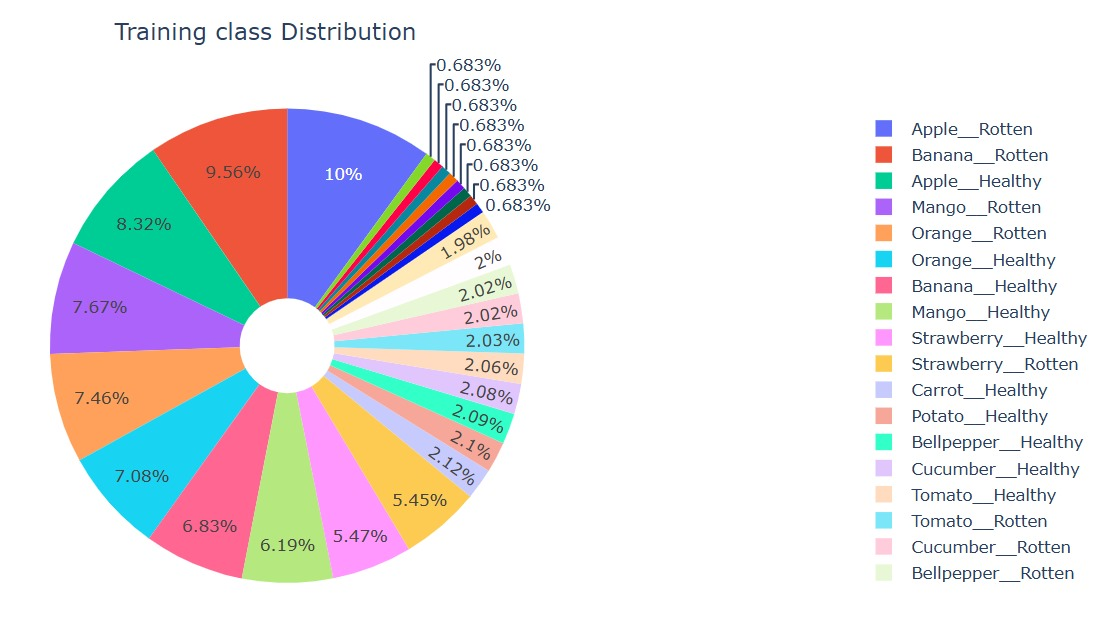

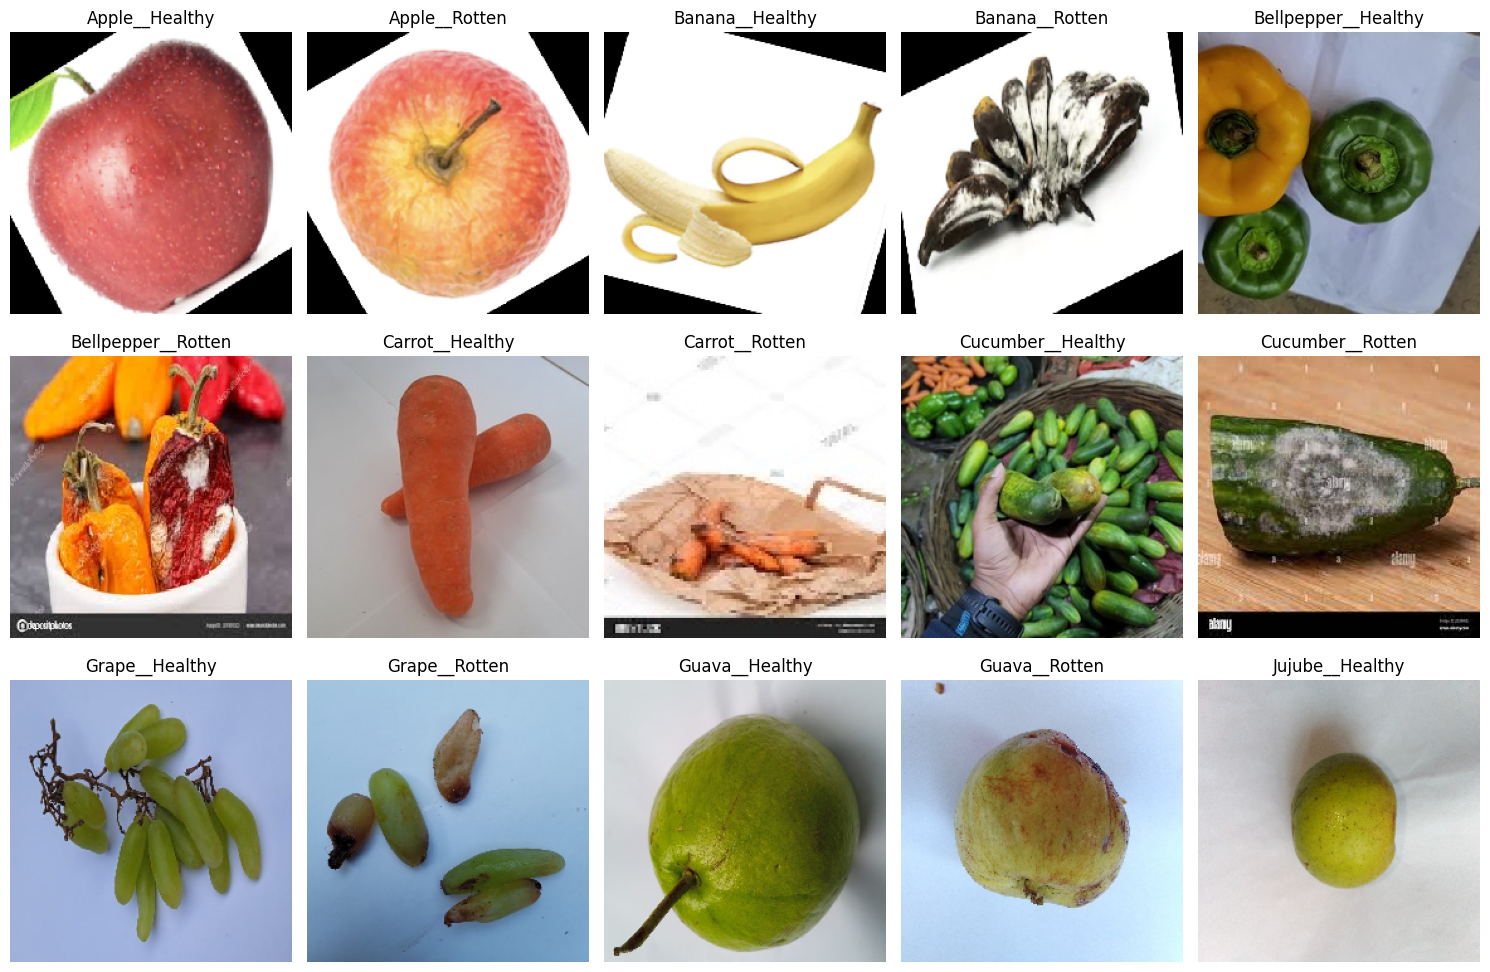

In [7]:
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(class_names[:15]):
    class_path = os.path.join(data_dir, class_name)

    image_file = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_file)

    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0

    plt.subplot(3, 5, i + 1)
    plt.imshow(img_array)
    plt.axis("off")
    plt.title(class_name)

plt.tight_layout()
plt.show()


### 3.Data Preparation: Creating Training and Validation Sets


<div style=" padding: 5px; border-radius: 12px; box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3); margin-top: 20px;">
    <h2 style="color: #f39c12; font-family: 'Helvetica Neue', sans-serif; text-align: center; font-size: 36px; margin-bottom: 15px;">
         Data Preprocessing with ImageDataGenerator
    </h2>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 26px; text-align: center; line-height: 1.6;">
        The <strong>ImageDataGenerator</strong> is used to preprocess the dataset by rescaling pixel values
        and 
        splitting the data into training and validation sets.
        It helps improve model generalization and prevents overfitting.
    </p>
    
    
</div>


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255,
    validation_split=0.25
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25
)


In [10]:
batch_size = 64
img_size = (224, 224)

In [ ]:
train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    subset="training"
)

valid_data = val_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    subset="validation"
)


Found 21967 images belonging to 28 classes.
Found 7310 images belonging to 28 classes.


In [12]:
print(f"Classes: {train_data.class_indices}")
print(f"Train samples: {train_data.samples}, Valid samples: {valid_data.samples}")

Classes: {'Apple__Healthy': 0, 'Apple__Rotten': 1, 'Banana__Healthy': 2, 'Banana__Rotten': 3, 'Bellpepper__Healthy': 4, 'Bellpepper__Rotten': 5, 'Carrot__Healthy': 6, 'Carrot__Rotten': 7, 'Cucumber__Healthy': 8, 'Cucumber__Rotten': 9, 'Grape__Healthy': 10, 'Grape__Rotten': 11, 'Guava__Healthy': 12, 'Guava__Rotten': 13, 'Jujube__Healthy': 14, 'Jujube__Rotten': 15, 'Mango__Healthy': 16, 'Mango__Rotten': 17, 'Orange__Healthy': 18, 'Orange__Rotten': 19, 'Pomegranate__Healthy': 20, 'Pomegranate__Rotten': 21, 'Potato__Healthy': 22, 'Potato__Rotten': 23, 'Strawberry__Healthy': 24, 'Strawberry__Rotten': 25, 'Tomato__Healthy': 26, 'Tomato__Rotten': 27}
Train samples: 21967, Valid samples: 7310


### 5. Building the ResNet50V2 Model 

<div style="padding: 5px; border-radius: 12px; box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3); margin-top: 20px;">
    <h2 style="color: #f1c40f; font-family: 'Helvetica Neue', sans-serif; text-align: center; font-size: 36px; margin-bottom: 15px;">
        ResNet50V2: Advanced Deep Learning Model
    </h2>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 26px; text-align: center; line-height: 1.6;">
        ResNet50V2 is an improved version of the original ResNet architecture, designed to tackle the
        <strong>vanishing gradient problem</strong> in deep networks. By utilizing <strong>residual connections</strong>, it
        enables efficient feature learning and enhances gradient flow through the network.
        <br><br>
        This model is widely used in <strong>image classification, object detection, and feature extraction</strong>,
        making it an excellent choice for transfer learning applications. Its deeper architecture allows it to capture
        intricate patterns in images, leading to superior performance on complex datasets.
    </p>
</div>


<div style="padding: 25px; border-radius: 12px; box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3); margin-top: 20px;">
    <h1 style="color: #f1c40f; font-family: 'Helvetica Neue', sans-serif; text-align: center; font-size: 36px; margin-bottom: 16 ;">
        Constructing the ResNet50V2 Model 
    </h1>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 26px; text-align: center; line-height: 1.6;">
        We leverage <strong>ResNet50V2</strong> as a feature extractor with pre-trained <strong>ImageNet</strong> weights.
        The base model remains <strong>frozen</strong> to preserve learned representations, while custom fully connected layers
        refine the classification process. This architecture ensures a balance between feature richness and computational efficiency.
    </p>
</div>


In [13]:
# 1. Base ResNet50V2 Model with Pretrained Weights
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    weights='imagenet'
)

base_model.trainable = False  # Freeze ResNet layers

inputs = layers.Input(shape=(224, 224, 3))

x = base_model(inputs)

x = layers.Dropout(0.1)(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(28, activation='softmax')(x)

resnet_model = models.Model(inputs, outputs)

# 6. AdamW Optimizer with Adjustable Learning Rate
optimizer = optimizers.AdamW(learning_rate=1e-3)  # Higher Learning Rate

resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

resnet_model.summary()



94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,831,196 (90.91 MB)

 Trainable params: 266,140 (1.02 MB)

 Non-trainable params: 23,565,056 (89.89 MB)

#### 5.1  Pre-Fine-Tuning Training the ResNet50V2

In [14]:
history_ResNet = resnet_model.fit(train_data, validation_data=valid_data, epochs=6)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/6
 84/344 ━━━━━━━━━━━━━━━━━━━━ 8:11 2s/step - accuracy: 0.4899 - loss: 2.1364

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



344/344 ━━━━━━━━━━━━━━━━━━━━ 778s 2s/step - accuracy: 0.6733 - loss: 1.3757 - val_accuracy: 0.8897 - val_loss: 0.5527
Epoch 2/6
344/344 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.8571 - loss: 0.6262 - val_accuracy: 0.9023 - val_loss: 0.5009
Epoch 3/6
344/344 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.8731 - loss: 0.5544 - val_accuracy: 0.9134 - val_loss: 0.4397
Epoch 4/6
344/344 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.8857 - loss: 0.5041 - val_accuracy: 0.9123 - val_loss: 0.4546
Epoch 5/6
344/344 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.8890 - loss: 0.4841 - val_accuracy: 0.9218 - val_loss: 0.4197
Epoch 6/6
344/344 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.8865 - loss: 0.4874 - val_accuracy: 0.9124 - val_loss: 0.4484


## 5.2  Fine-Tuning the ResNet50V2 for Enhanced Accuracy

In [15]:
# Unfreezing ResNet50V2 layers for Fine-Tuning
base_model.trainable = True

# Reduce Learning Rate for Fine-Tuning
optimizer = optimizers.AdamW(learning_rate=1e-4)

# Recompile the model with a lower learning rate
resnet_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Full training with Fine-Tuning
history_ResNet = resnet_model.fit(train_data, validation_data=valid_data, epochs=8)
resnet_model.save("healthy_rotten_resnet_model.h5")





Epoch 1/8
344/344 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - accuracy: 0.8737 - loss: 0.5284 - val_accuracy: 0.9079 - val_loss: 0.5450
Epoch 2/8
344/344 ━━━━━━━━━━━━━━━━━━━━ 588s 2s/step - accuracy: 0.9466 - loss: 0.2968 - val_accuracy: 0.9267 - val_loss: 0.4379
Epoch 3/8
344/344 ━━━━━━━━━━━━━━━━━━━━ 589s 2s/step - accuracy: 0.9534 - loss: 0.2711 - val_accuracy: 0.9398 - val_loss: 0.3708
Epoch 4/8
344/344 ━━━━━━━━━━━━━━━━━━━━ 584s 2s/step - accuracy: 0.9683 - loss: 0.2231 - val_accuracy: 0.9268 - val_loss: 0.4453
Epoch 5/8
344/344 ━━━━━━━━━━━━━━━━━━━━ 587s 2s/step - accuracy: 0.9693 - loss: 0.2085 - val_accuracy: 0.9445 - val_loss: 0.3817
Epoch 6/8
344/344 ━━━━━━━━━━━━━━━━━━━━ 588s 2s/step - accuracy: 0.9732 - loss: 0.1879 - val_accuracy: 0.9350 - val_loss: 0.4272
Epoch 7/8
344/344 ━━━━━━━━━━━━━━━━━━━━ 581s 2s/step - accuracy: 0.9770 - loss: 0.1753 - val_accuracy: 0.9289 - val_loss: 0.5378
Epoch 8/8
344/344 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - accuracy: 0.9735 - loss: 0.1736 - val_accuracy: 0.

## 5.3  Model Performance: Accuracy, Errors & Insights

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step


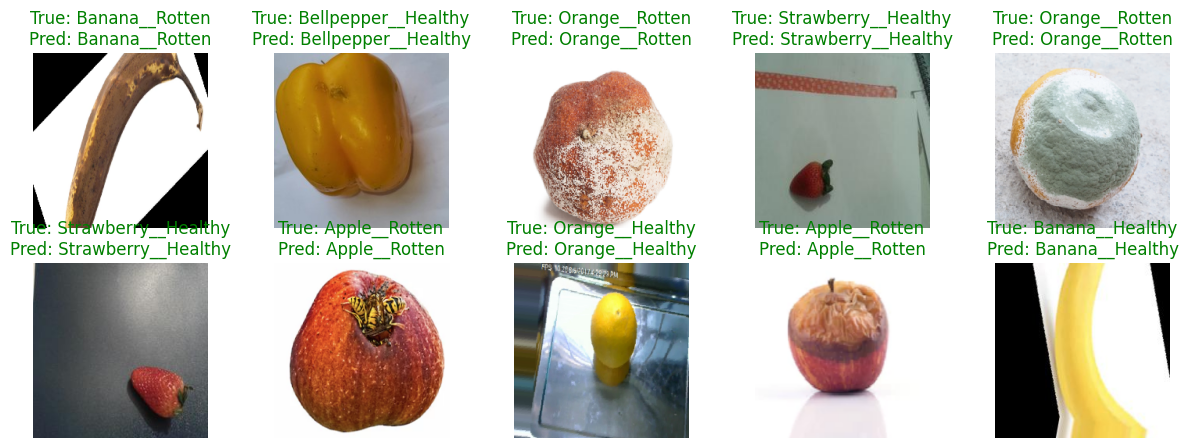

In [19]:
# Fetch a batch from validation data
valid_data.reset()
images, labels = next(valid_data)

# Get predictions
predictions = resnet_model.predict(images)

# Convert outputs to predicted classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

# Display images with predictions
plt.figure(figsize=(15, 5))
for i in range(10):  # Display first 10 images
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

    true_label = list(valid_data.class_indices.keys())[true_classes[i]]
    pred_label = list(valid_data.class_indices.keys())[predicted_classes[i]]

    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


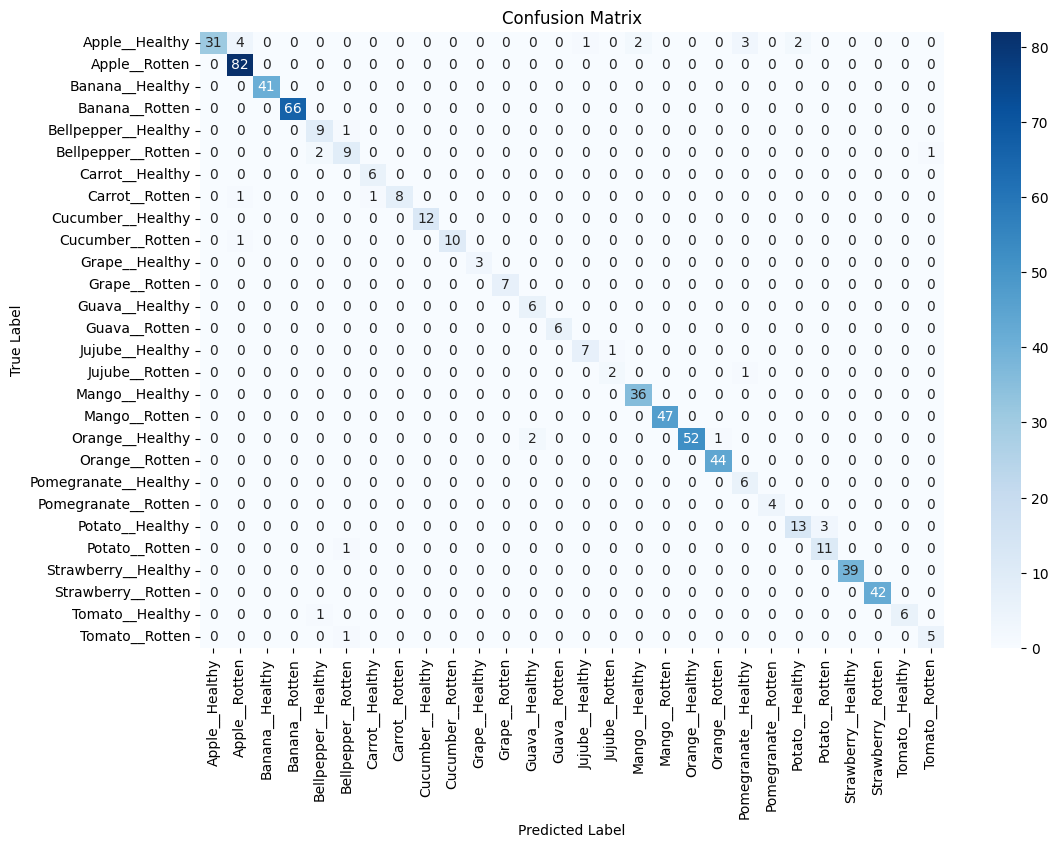

                      precision    recall  f1-score   support

      Apple__Healthy       1.00      0.72      0.84        43
       Apple__Rotten       0.93      1.00      0.96        82
     Banana__Healthy       1.00      1.00      1.00        41
      Banana__Rotten       1.00      1.00      1.00        66
 Bellpepper__Healthy       0.75      0.90      0.82        10
  Bellpepper__Rotten       0.75      0.75      0.75        12
     Carrot__Healthy       0.86      1.00      0.92         6
      Carrot__Rotten       1.00      0.80      0.89        10
   Cucumber__Healthy       1.00      1.00      1.00        12
    Cucumber__Rotten       1.00      0.91      0.95        11
      Grape__Healthy       1.00      1.00      1.00         3
       Grape__Rotten       1.00      1.00      1.00         7
      Guava__Healthy       0.75      1.00      0.86         6
       Guava__Rotten       1.00      1.00      1.00         6
     Jujube__Healthy       0.88      0.88      0.88         8
      J

In [20]:
# Limit the number of batches processed to prevent high memory usage
num_batches = 10  # Number of batches to process

y_pred_probs = []
y_true = []

# Fetch a limited number of batches from valid_data
for i, (images, labels) in enumerate(valid_data):
    if i >= num_batches:  # Restrict processing to 10 batches
        break
    preds = resnet_model.predict(images)
    y_pred_probs.append(preds)
    y_true.append(labels)

# Concatenate all batches
y_pred_probs = np.concatenate(y_pred_probs, axis=0)
y_true = np.concatenate(y_true, axis=0)

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


In [ ]:
# Compute error rate for each class
errors_per_class = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)
error_rate_per_class = errors_per_class / np.sum(conf_matrix, axis=1)

# Display classes with the highest error rate
sorted_errors = sorted(zip(class_names, error_rate_per_class), key=lambda x: x[1], reverse=True)
print("📌 Classes with the highest error rate:")
for cls, error in sorted_errors[:5]:  # Show top 5 misclassified classes
    print(f"{cls}: {error:.2%} error")


📌 Classes with the highest error rate:
Jujube__Rotten: 33.33% error
Apple__Healthy: 27.91% error
Bellpepper__Rotten: 25.00% error
Carrot__Rotten: 20.00% error
Potato__Healthy: 18.75% error
